In [36]:
%%time

#### Dependencies
%matplotlib inline
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Functions.Preprocess import tracks_to_df
from Functions.Models import train, lstm_mask, cnn
import tensorflow as tf
import sklearn.metrics
#### Jupyter notebook flag
nb = True
#### Hard coded parameters
N = 10000  # Total number of events in data
max_ev = 1e6 # Maximum number of events to load (before PT and 2jet cuts)
r = 0.5  # Signal proportion from total events
mult_thresh = 15  # Jet1 multiplicity threshold for initial cut
model_type = cnn # Model for classification
model_name = "cnn" # Where to save weights
bkg_path = ["Data/for_semi_supervised_new/0.{}.5000.0.5.0.50.150.200.root.GetTracks.0.7.txt".format(i) for i in range(50)]
sig_path = ["Data/for_semi_supervised_new/1.{}.5000.0.5.0.50.150.500.root.GetTracks.0.7.txt".format(i) for i in range(50)]
n_constits = 50
mask = 0.0
sort = "PT"
feats = ["track_D0", "track_DZ"] + ["track_PT", "track_Eta", "track_Phi"] 
jet_feats = ["jet_PT", "jet_Eta", "jet_Phi"]
PT_cut = (-1000, 1000)
val_frac = 0.2
epochs = 20
analysis_dir = "Analysis/Semi-supervised/{}_{}_{}/".format(model_name, n_constits, r)

Path(analysis_dir).mkdir(parents=True, exist_ok=True)
#### Inputs
if not nb:
    os.chdir("/gpfs0/kats/users/wunch/dark_jets_repo/")
    analysis_dir = str(sys.argv[1])
    epochs = int(sys.argv[2])
    N = float(sys.argv[3])
    r = float(sys.argv[4])
    os.makedirs(analysis_dir, exist_ok=True)
    bkg_path = ["/gpfs0/kats/users/wunch/cluster_out/bb{}.root.GetTracks.txt".format(i) for i in range(1, 5)]
    sig_path = ["/gpfs0/kats/users/wunch/cluster_out/dark{}.root.GetTracks.txt".format(i) for i in range(1, 5)]

#### Preprocessing
# Load signal and background
bkg_j = tracks_to_df(bkg_path, label=0, max_ev=max_ev, n_constits=n_constits, trunc=False, PT_cut=PT_cut, sort=sort) 
sig_j = tracks_to_df(sig_path, label=1, max_ev=max_ev, n_constits=n_constits, trunc=False, PT_cut=PT_cut, sort=sort)
# Clean single jet events
bkg_evs_2jet = bkg_j.Event.value_counts()[bkg_j.Event.value_counts() > 1].index  # Events with two jets
sig_evs_2jet = sig_j.Event.value_counts()[sig_j.Event.value_counts() > 1].index
print("Number of Background events with two jets is ", len(bkg_evs_2jet), " out of ", len(bkg_j.Event.value_counts())) # Output number of events with two jets
print("Number of Signal events with two jets is ",len(sig_evs_2jet), " out of ", len(sig_j.Event.value_counts()))
print("----------")
bkg_j = bkg_j.loc[bkg_j.Event.map(lambda x: x in bkg_evs_2jet)].reset_index() # Clean single jet events
sig_j = sig_j.loc[sig_j.Event.map(lambda x: x in sig_evs_2jet)].reset_index()
# Group by jet
bkg_j1 = bkg_j[bkg_j.Jet == 1][['Event'] + feats + jet_feats + ['label']]  # Seperate
bkg_j2 = bkg_j[bkg_j.Jet == 2][['Event'] + feats + jet_feats]
bkg_j1 = bkg_j1.rename(columns={feat: feat+"1" for feat in (feats+jet_feats)})  # Rename
bkg_j2 = bkg_j2.rename(columns={feat: feat+"2" for feat in (feats+jet_feats)})
bkg_ev = pd.merge(bkg_j2, bkg_j1, on='Event')  # Merge
sig_j1 = sig_j[sig_j.Jet == 1][['Event'] + feats + jet_feats + ['label']] # Seperate
sig_j2 = sig_j[sig_j.Jet == 2][['Event'] + feats + jet_feats]
sig_j1 = sig_j1.rename(columns={feat : feat+"1" for feat in (feats+jet_feats)}) # Rename
sig_j2 = sig_j2.rename(columns={feat : feat+"2" for feat in (feats+jet_feats)})
sig_ev = pd.merge(sig_j2, sig_j1, on='Event') # Merge
# Create data sample with specified proportions
data = pd.concat([sig_ev.loc[:int(N*r)], bkg_ev.loc[:int(N*(1-r))]]).sample(frac=1).reset_index(drop=True)
print("N = ", len(data))
print("#B = ", len(data[(data.label == 0)]))
print("#S = ", len(data[(data.label == 1)]))
print("----------")
#### Seperate events into two groups S' (mult_thres=1) B'(mult_thresh=0) by cutting on jet1 multiplicity
data["j1_mult"] = data.track_PT1.map(lambda x: len(x))
data["j1_mult_cut"] = (data.j1_mult > mult_thresh).astype(np.int)
# Output cut efficiencies
B_tag_SNR = len(data[(data.j1_mult_cut == 0) & (data.label == 1)]) / len(data[data.j1_mult_cut == 0])
S_tag_SNR = len(data[(data.j1_mult_cut == 1) & (data.label == 1)]) / len(data[data.j1_mult_cut == 1])
print("#B' = {} with S/(B+S) of {:.2f}%".format(len(data[(data.j1_mult_cut == 0)]), B_tag_SNR*100))
print("#S' = {} with S/(B+S) of {:.2f}%".format(len(data[(data.j1_mult_cut == 1)]), S_tag_SNR*100))
print("Background efficiencey of multiplicity cut is {:.2f}".format(len(data[(data.label == 0) & (data.j1_mult_cut == 1)])/len(data[data.label == 0])))
print("Signal efficiencey of multiplicity cut is {:.2f}".format(len(data[(data.label == 1) & (data.j1_mult_cut == 1)])/len(data[data.label == 1])))
print("----------")
# Preprocessing for NN
data.track_PT2 = data.track_PT2 / data.track_PT2.map(np.max)  # Scale and shift
data.track_Eta2 = (data.track_Eta2 - data.jet_Eta2) * 10
data.track_Phi2 = (data.track_Phi2 - data.jet_Phi2) * 10
data.track_DZ2 = data.track_DZ2 / np.cosh(data.jet_Eta2)
# Reshape for NN
min_counts_class = data.j1_mult_cut.value_counts().min()
balanced_idxs = data.groupby('j1_mult_cut', group_keys=False).apply(lambda x: x.sample(min_counts_class)).sample(frac=1).index
j2_feats_for_nn = np.array([np.vstack(data[feat+"2"].apply(lambda x: np.append(x[:n_constits], [mask] * (n_constits - len(x))))) for feat in feats]).swapaxes(0,1).swapaxes(1,2)
data['j2_mult'] = data.track_PT2.map(lambda x: len(x))
data['avg_jet_mult'] = (data.j1_mult + data.j2_mult)/2
print("N_for_nn = {}".format(min_counts_class)) 
print("NN input shape = {}".format(j2_feats_for_nn[balanced_idxs].shape))

Wall time: 3min 7s


In [354]:
a = np.vstack(data[[feat+"2" for feat in feats]].apply(lambda x: np.append(x[:n_constits], [mask] * (n_constits - len(x)))).values)

In [401]:
d = np.array([np.vstack(data[feat+"2"].apply(lambda x: np.append(x[:n_constits], [mask] * (n_constits - len(x))))) for feat in feats]).swapaxes(0,1).swapaxes(1,2)
#a = data[[feat+"2" for feat in feats]].applymap(lambda x: np.append(x[:n_constits], [mask] * (n_constits - len(x)))).values

In [402]:
d[0, :, 2]

array([1.        , 0.61460892, 0.53779917, 0.511199  , 0.28851604,
       0.17658868, 0.08265586, 0.03192373, 0.0135108 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [352]:
print(np.array(np.vstack(a[:,1])).shape)
print(np.array(np.vstack(a[:,2])[0]))

(1002, 25)
[1.         0.61460892 0.53779917 0.511199   0.28851604 0.17658868
 0.08265586 0.03192373 0.0135108  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


In [294]:
i = 0
a[i,:,0]

array([ 0.0434364 ,  0.118375  ,  0.        ,  0.        ,  0.        ,
        0.01463998, -0.16315573,  0.        ,  0.        ,  0.        ,
        1.        ,  0.17658868,  0.        ,  0.        ,  0.        ,
       -0.3101    , -0.229     ,  0.        ,  0.        ,  0.        ,
        0.1419    ,  1.0513    ,  0.        ,  0.        ,  0.        ])

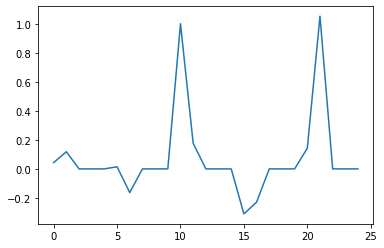

In [253]:
plt.plot(j2_feats_for_nn[i,:,0])

In [92]:
j2_feats_for_nn[balanced_idxs].shape

(802, 10, 5)

In [86]:
balanced_idxs = data.groupby('j1_mult_cut', group_keys=False).apply(lambda x: x.sample(min_counts_class)).index

In [89]:
data.iloc[balanced_idxs].Event.value_counts()

533     2
722     2
732     2
191     2
221     2
       ..
604     1
603     1
602     1
601     1
1498    1
Name: Event, Length: 707, dtype: int64

In [85]:
data.head()

,Event,track_D02,track_DZ2,track_PT2,track_Eta2,track_Phi2,jet_PT2,jet_Eta2,jet_Phi2,track_D01,...,track_Eta1,track_Phi1,jet_PT1,jet_Eta1,jet_Phi1,label,j1_mult,j1_mult_cut,j2_mult,avg_jet_mult
0,1468,"[-0.454777, 0.232329, -0.315743, -0.186072, -0...","[-0.31472248551934157, -0.3285856693001487, -0...","[1.0, 0.3586472609864277, 0.2607395572420412, ...","[3.103600000000002, 2.839900000000002, 3.00120...","[-0.6101000000000001, 4.207799999999997, -0.37...",90.4536,-2.742830,1.746490,"[0.229919, -0.0487672, 0.585284, -0.519596, 1....",...,"[-0.261669, -0.660214, -0.370826, -0.199461, -...","[-1.31944, -1.56264, -1.28373, -1.41127, -1.18...",114.060,-0.369906,-1.334330,1,24,1,7,15.5
1,592,"[-0.0149432, 0.121824, 0.00701952, 0.871978, -...","[-0.038904424298464545, -0.03375270223892797, ...","[1.0, 0.2315058823529412, 0.22088976034858387,...","[-0.06558999999999982, 0.5811700000000009, -1....","[0.045600000000000085, -0.17432000000000003, -...",123.8240,0.991993,-0.602912,"[0.00356064, -0.172532, -0.140108, -0.251207, ...",...,"[0.113767, 0.123877, 0.140044, 0.160243, 0.154...","[2.54355, 2.57839, 2.5744, 2.56211, 2.50888, 2...",150.904,0.138927,2.570490,0,10,0,9,9.5
2,440,"[-0.0689225, 0.0507593, 0.00346948, 0.071354, ...","[0.081173165523364, 0.005669047538053761, 0.07...","[1.0, 0.8456548634099041, 0.3279257364496606, ...","[-0.21689999999999987, -0.23820000000000174, -...","[-0.2526000000000006, -0.8794999999999997, -0....",105.0480,2.457850,-1.292230,"[-0.0278063, 0.00221042, 0.380758, 0.0601067, ...",...,"[-0.56707, -0.763904, -0.752238, -0.550493, -0...","[1.86894, 1.95146, 2.0134, 2.42219, 2.4164, 1....",154.004,-0.596492,2.121610,0,23,1,6,14.5
3,394,"[0.036185, 0.0460968, -24.6735, -1.01593, 136....","[0.05052015675108247, 0.038902289857535605, 3....","[1.0, 0.8298063930455445, 0.6307014277885383, ...","[-0.7759399999999994, 0.24500000000000077, 2.6...","[0.7963999999999993, -1.3263000000000025, -2.0...",133.8800,-0.840064,-2.135270,"[0.00779837, 0.36394, 0.0645288, -0.631471, 0....",...,"[-0.904776, -0.850263, -0.861897, -0.878929, -...","[1.0271, 1.04911, 1.03027, 0.984144, 1.02757, ...",150.993,-0.877347,1.012360,0,17,1,21,19.0
4,145,"[-0.22728, -0.0742942, 0.374569, -0.109248, -0...","[0.18927182778621074, -0.021112835044222178, -...","[1.0, 0.5800701914015534, 0.25320800701914015,...","[-0.3811999999999993, -0.018179999999999863, -...","[-0.519099999999999, -0.2748000000000017, 0.46...",89.8954,-0.863075,3.077000,"[0.2283, -0.238221, 0.0156261, 0.126558, -0.03...",...,"[0.839337, 0.824368, 0.550417, 0.610762, 0.890...","[0.162254, 0.105355, 0.16274, 0.312771, 0.1960...",157.520,0.824729,0.135172,0,7,0,8,7.5


In [33]:
data.j1_mult_cut.value_counts()

0    6430
1    3572
Name: j1_mult_cut, dtype: int64

In [48]:
data['j2_mult'] = data.track_PT2.map(lambda x: len(x))
data['avg_jet_mult'] = (data.j1_mult + data.j2_mult)/2

In [2]:
data[[feat + "2" for feat in feats]].head()

,track_D02,track_DZ2,track_PT2,track_Eta2,track_Phi2
0,"[-0.0127032, -0.0502641, -0.00603068, 0.137381...","[0.013614717726451215, -0.04546458196260107, -...","[1.0, 0.8195331814772633, 0.5879503597322149, ...","[0.12150000000000105, -0.15309999999999935, 0....","[-0.02006999999999981, 0.27764999999999984, 0...."
1,"[-0.318095, -0.130386, -0.364955, 0.144333, -0...","[0.1223681833579823, 0.5125382952680142, 0.273...","[1.0, 0.08232113751109817, 0.06251673005313862...","[0.07800000000000029, -0.40240000000000054, 0....","[-0.31320000000000014, -0.2534000000000014, -1..."
2,"[-0.0176417, 0.000309835, 0.0214445, 0.0385926...","[0.013187658911069903, -0.014664994906538439, ...","[1.0, 0.5691823522957377, 0.5086243528742855, ...","[-0.9000399999999997, 1.0026000000000002, 0.92...","[-0.36966000000000054, -0.8170699999999997, -1..."
3,"[0.00439138, -0.0611179, -0.000355016, -0.0690...","[-0.011819582392492547, -0.08929304326020214, ...","[1.0, 0.3313561744835161, 0.2902697903970869, ...","[1.451880000000001, 0.7271100000000008, -1.424...","[-0.06394999999999929, 0.0022900000000003473, ..."
4,"[-0.616415, -0.169709, 1.56972, 0.757873, -0.2...","[0.3087114918549048, 0.09981391257536122, -0.0...","[1.0, 0.39295274493251714, 0.16732227968054156...","[-0.21809999999999885, -0.12159999999999727, -...","[-0.8212999999999981, -0.5772999999999984, 0.1..."


(0.0, 0.007384714469729498)

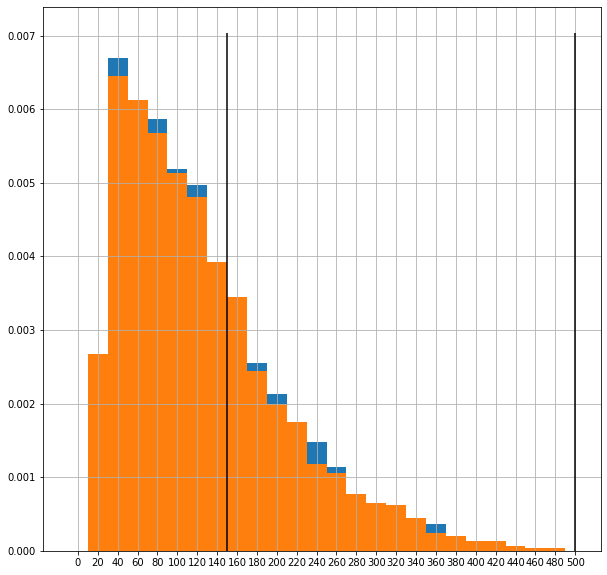

In [33]:
PT_range = (0, 1000)
data[data.label==1].jet_PT2.hist(bins=np.arange(-10, 500, 20), density=True)
data[data.label==1].jet_PT1.hist(bins=np.arange(-10, 500, 20), density=True)
plt.gcf().set_size_inches(10, 10)
plt.xticks(np.arange(-10, 500, 20)+10);
plt.vlines([150, 500], *plt.gca().get_ylim(), color='black')
plt.gca().get_ylim()

(0.0, 145.53)

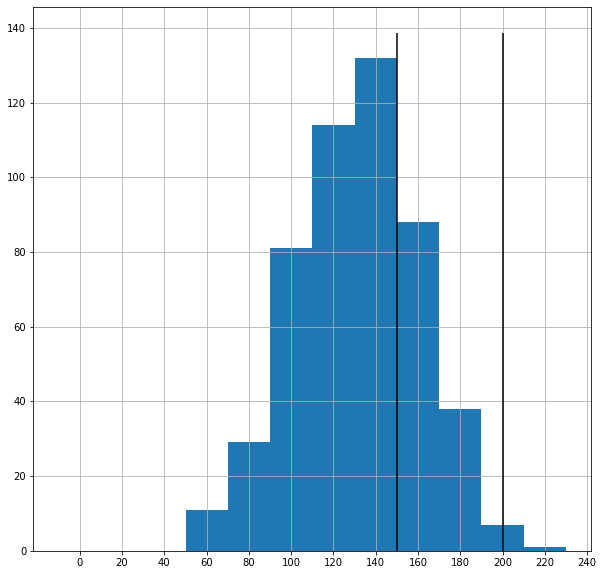

In [31]:
data[data.label==0].jet_PT2.hist(bins=np.arange(-10, 240, 20))
plt.gcf().set_size_inches(10, 10)
plt.xticks(np.arange(-10, 500, 20)+10);
plt.vlines([150, 200], *plt.gca().get_ylim(), color='black')
plt.gca().get_ylim()

c:\users\noamw\desktop\jet_tagging\venv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


Wall time: 340 ms


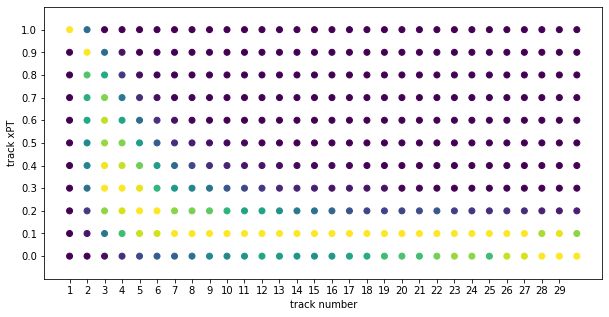

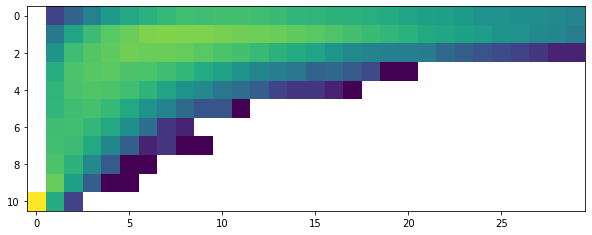

In [25]:
%%time
im = []
plt.close('all')
data[[feat+"2" for feat in feats]] = data[[feat+"2" for feat in feats]].applymap(lambda x: np.append(x[:n_constits], [np.nan] * (n_constits - len(x))))
plt.figure()
for i in range(n_constits):
    counts, bins = np.histogram(data.track_PT2.map(lambda x: x[i]), bins=np.arange(-0.05,1.1,0.1))
    plt.scatter(y=bins[:-1]+(bins[1]-bins[0])/2, x=(i+1)*np.ones(counts.shape), c=counts)
    im.append(np.log(counts))
plt.ylim(-0.1, 1.1)    
plt.xticks(np.arange(1, n_constits))
plt.xlabel('track number')
plt.yticks(bins[:-1]+(bins[1]-bins[0])/2)
plt.ylabel('track xPT')
plt.gcf().set_size_inches(10, 5)
plt.figure()
plt.imshow(np.flinp.transpose(im))
plt.gcf().set_size_inches(10, 10)

c:\users\noamw\desktop\jet_tagging\venv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


Wall time: 278 ms


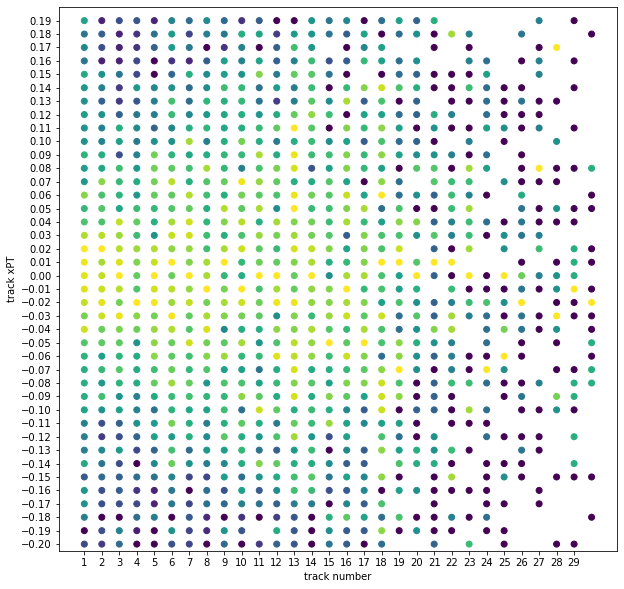

In [14]:
%%time
feature = 'track_DZ2'
plt.close('all')
plt.figure()
im = []
for i in range(n_constits):
    counts, bins = np.histogram(data[feature].map(lambda x: x[i]), bins=np.arange(-0.205, 0.2, 0.01))
    counts = np.log(counts/sum(counts))
    plt.scatter(y=bins[:-1]+(bins[1]-bins[0])/2, x=(i+1)*np.ones(counts.shape), c=counts)
    im.append(counts)
plt.ylim(-0.205, 0.2)    
plt.xticks(np.arange(1, n_constits))
plt.xlabel('track number')
plt.yticks(bins[:-1]+(bins[1]-bins[0])/2)
plt.ylabel('track xPT')
plt.gcf().set_size_inches(10, 10)

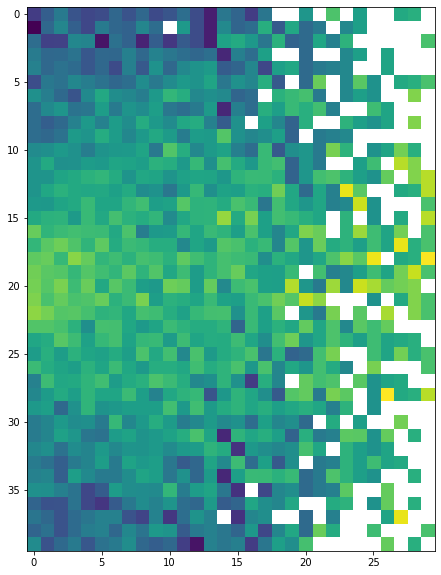

In [19]:
plt.imshow(np.transpose(im))
plt.gcf().set_size_inches(10, 10)

In [102]:
plt.figure()
data[feature].map(lambda x: x[0]).hist(bins=np.arange(-1.05, 1, 0.1), density=True)
data[feature].map(lambda x: x[3]).hist(bins=np.arange(-1.05, 1, 0.1), density=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:>

In [107]:
data.iloc[1][feature]

array([ 2.60629 ,  1.4228  , -3.073186, -2.813427, -1.1396  , -1.33532 ,
        0.57172 , -0.23688 , -5.79012 , -0.75833 ,  4.57852 , -5.11203 ,
        1.8963  , -2.479776, -0.76362 , -0.15143 , -3.386963, -0.32082 ,
        0.20733 , -0.05846 ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ])

# Testing 1

In [ ]:
data.head()

In [12]:
data["j2_mult"] = data.track_PT2.map(lambda x: len(x))

In [16]:
label = 1
plt.figure()
data[data.label==label]['j1_mult'].hist(bins=np.arange(0.5, 45, 1), color='black', histtype="step", hatch="x")
data[data.label==label]['j2_mult'].hist(bins=np.arange(0.5, 45, 1), color='red', histtype="step", hatch="o")
plt.gcf().set_size_inches(10, 10)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

count    5001.000000
mean      171.063051
std        28.807095
min        68.861600
25%       153.087000
50%       169.029000
75%       186.200000
max       322.466000
Name: jet_PT1, dtype: float64
count    5001.000000
mean      132.630029
std        28.459413
min        39.063600
25%       113.684000
50%       134.735000
75%       152.787000
max       230.653000
Name: jet_PT2, dtype: float64


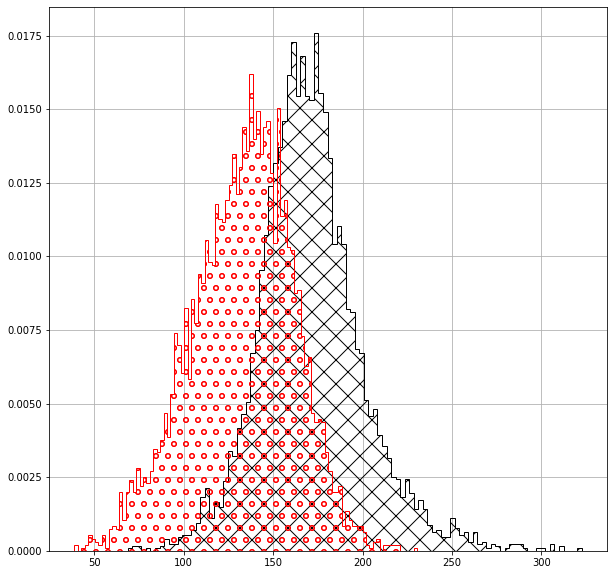

In [40]:
label = 0
data[data.label==label]['jet_PT1'].hist(color='black', histtype="step", hatch="x", bins=100, density=True)
data[data.label==label]['jet_PT2'].hist(color='red', histtype="step", hatch="o", bins=100, density=True)
plt.gcf().set_size_inches(10, 10)
print(data[data.label==0]['jet_PT1'].describe())
print(data[data.label==0]['jet_PT2'].describe())

count    5001.000000
mean      171.063051
std        28.807095
min        68.861600
25%       153.087000
50%       169.029000
75%       186.200000
max       322.466000
Name: jet_PT1, dtype: float64
count    5001.000000
mean      124.934449
std        84.923449
min        23.201500
25%        61.480600
50%       106.330000
75%       164.783000
max       878.529000
Name: jet_PT1, dtype: float64


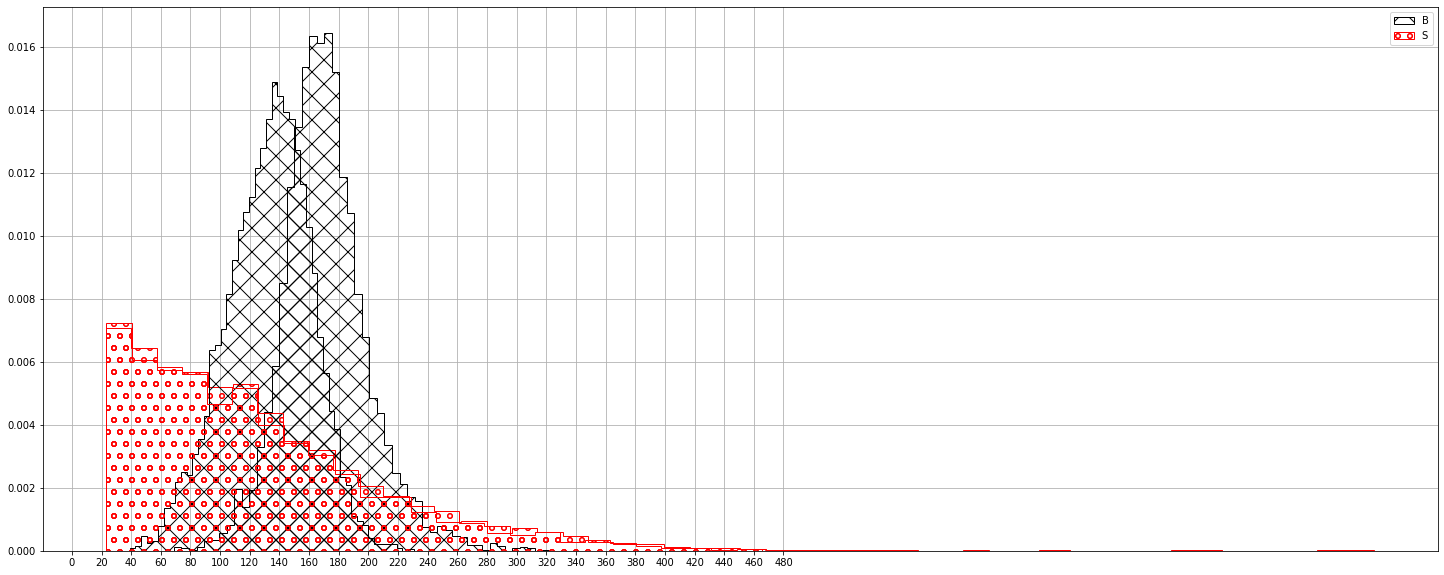

In [41]:
PT_range = (0, 1000)
data[data.label==0]['jet_PT1'][data[data.label==0].jet_PT1.between(*PT_range)].hist(color='black', histtype="step", hatch="x", bins=50, density=True)
data[data.label==1]['jet_PT1'][data[data.label==1].jet_PT1.between(*PT_range)].hist(color='red', histtype="step", hatch="o", bins=50, density=True)
data[data.label==0]['jet_PT2'][data[data.label==0].jet_PT2.between(*PT_range)].hist(color='black', histtype="step", hatch="x", bins=50, density=True)
data[data.label==1]['jet_PT2'][data[data.label==1].jet_PT2.between(*PT_range)].hist(color='red', histtype="step", hatch="o", bins=50, density=True)
plt.gcf().set_size_inches(25, 10)
print(data[data.label==0]['jet_PT1'].describe())
print(data[data.label==1]['jet_PT1'].describe())
plt.legend(['B', 'S'])
plt.xticks(np.arange(0,500,20));

Text(0.5, 0, 'j1_mult')

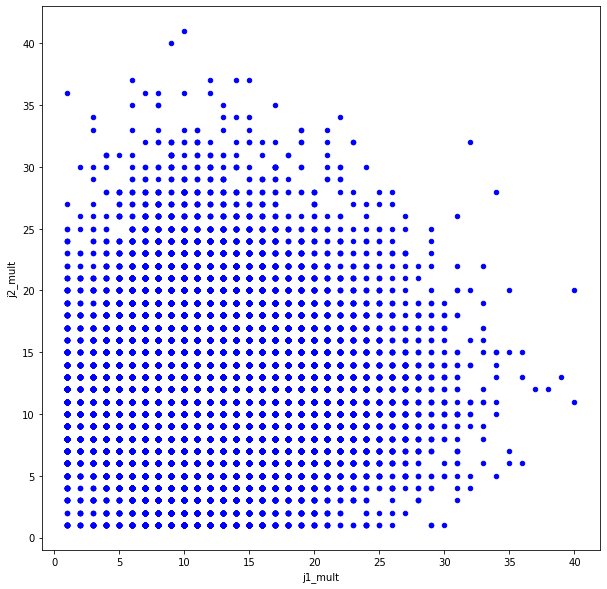

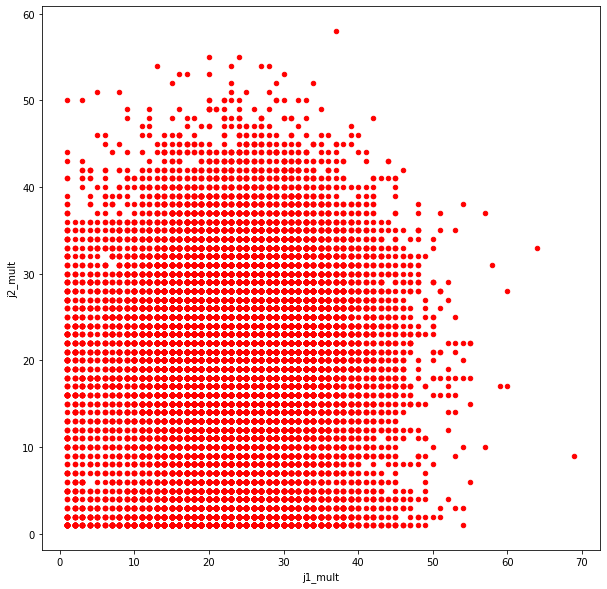

In [26]:
data[data.label==0].plot.scatter('j1_mult', 'j2_mult', c='blue');
plt.gcf().set_size_inches(10, 10)
plt.xlabel('j1_mult')
data[data.label==1].plot.scatter('j1_mult', 'j2_mult', c='red');
plt.gcf().set_size_inches(10, 10)
plt.xlabel('j1_mult')

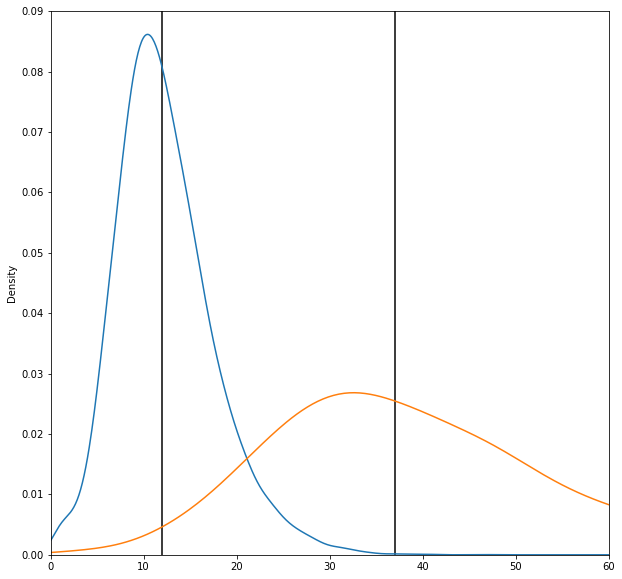

In [35]:
PT_range = (175, 225)
b_inrange_idxs = data[data.label==0].jet_PT1.between(*PT_range).index
s_inrange_idxs = data[data.label==1].jet_PT1.between(*PT_range).index
data.loc[b_inrange_idxs].j1_mult.plot.kde(bw_method=0.2)
data.loc[s_inrange_idxs].j1_mult.plot.kde(bw_method=0.2)
median_bkg = data[data.label==0].j1_mult.median()
median_sig = data[data.label==1].j1_mult.median()
plt.vlines(median_bkg, plt.ylim()[0], plt.ylim()[1], colors='black')
plt.vlines(median_sig, plt.ylim()[0], plt.ylim()[1], colors='black')
plt.xlim([0,60])
plt.ylim([0,0.09])
plt.gcf().set_size_inches(10, 10)

0.04817510603759753


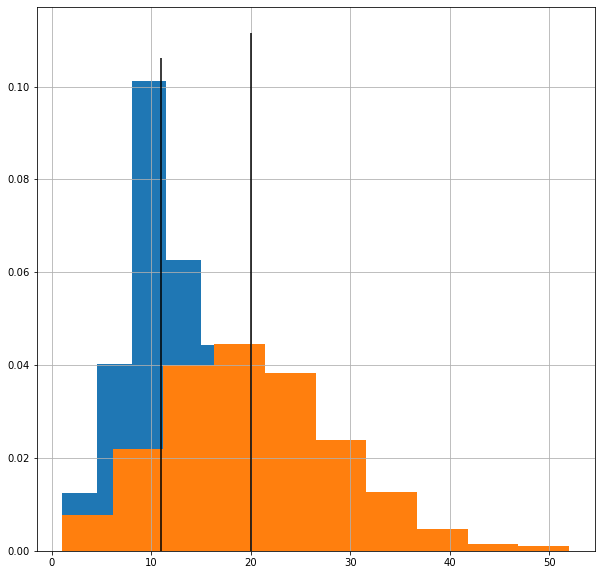

In [71]:
PT_range = (150, 175)
b_inrange_bool = (data.label==0) & (data.jet_PT1.between(*PT_range))
s_inrange_bool = (data.label==1) & (data.jet_PT1.between(*PT_range))
data[b_inrange_bool].j1_mult.hist(density=True)
data[s_inrange_bool].j1_mult.hist(density=True)
median_bkg = data[b_inrange_bool].j1_mult.median()
median_sig = data[s_inrange_bool].j1_mult.median()
plt.vlines(median_bkg, plt.ylim()[0], plt.ylim()[1], colors='black')
plt.vlines(median_sig, plt.ylim()[0], plt.ylim()[1], colors='black')
plt.gcf().set_size_inches(10, 10)
print(sum(data[b_inrange_bool].j1_mult>median_sig)/sum(b_inrange_bool))

In [48]:
len(data.iloc[b_inrange_idxs])

22730

In [29]:
len(b_inrange_idxs)

22730

In [31]:
b_inrange_idxs

3        False
4         True
6         True
7        False
10       False
         ...  
42469     True
42470    False
42473     True
42474     True
42475     True
Name: jet_PT1, Length: 22730, dtype: bool

In [30]:
len(data)

42476

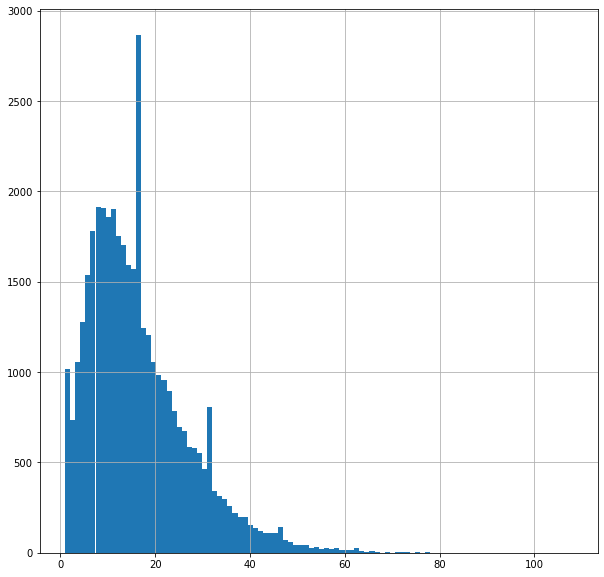

In [11]:
data[data.label==1].j1_mult.hist(bins=100)
plt.gcf().set_size_inches(10, 10)

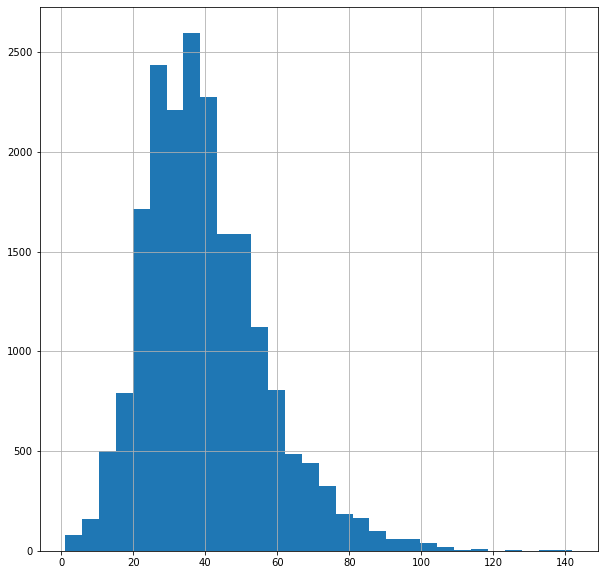

In [21]:
data[data.label==1].j1_mult.hist(bins=30)
plt.gcf().set_size_inches(10, 10)

In [17]:
len(data[data.label==1])

40696

In [82]:
print(data[data.label==0][['j1_mult', 'j2_mult']].corr())
print(data[data.label==1][['j1_mult', 'j2_mult']].corr())
print(data[data.label==1][['j1_mult', 'jet_PT2']].corr())
print(data[data.label==1][['j1_mult', 'jet_Eta2']].corr())
print(data[['j1_mult', 'j1_mult_cut']].corr())
print(data[['j1_mult', 'j2_mult']].corr())

          j1_mult   j2_mult
j1_mult  1.000000  0.021886
j2_mult  0.021886  1.000000
          j1_mult   j2_mult
j1_mult  1.000000  0.042092
j2_mult  0.042092  1.000000
          j1_mult   jet_PT2
j1_mult  1.000000  0.058675
jet_PT2  0.058675  1.000000
           j1_mult  jet_Eta2
j1_mult   1.000000 -0.003864
jet_Eta2 -0.003864  1.000000
              j1_mult  j1_mult_cut
j1_mult      1.000000     0.655524
j1_mult_cut  0.655524     1.000000
          j1_mult   j2_mult
j1_mult  1.000000  0.356437
j2_mult  0.356437  1.000000


In [59]:
data[['j1_mult', 'j2_mult']].corr()

,j1_mult,j2_mult
j1_mult,1.000000,0.239213
j2_mult,0.239213,1.000000


# Training

In [14]:
%%time
%%capture cap --no-stderr

#### Dependencies
%matplotlib inline
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Functions.Preprocess import tracks_to_df
from Functions.Models import train, lstm_mask, cnn
import tensorflow as tf
import sklearn.metrics
#### Jupyter notebook flag
nb = True
#### Hard coded parameters
N = 75000  # Total number of events in data
max_ev = 1e6 # Maximum number of events to load (before PT and 2jet cuts)
r = 0.2  # Signal proportion from total events
mult_thresh = 15  # Jet1 multiplicity threshold for initial cut
model_type = lstm_mask # Model for classification
model_name = "lstm" # Where to save weights
bkg_path = ["Data/for_semi_supervised_new/0.{}.5000.0.5.0.50.150.200.root.GetTracks.0.7.txt".format(i) for i in range(50)]
sig_path = ["Data/for_semi_supervised_new/1.{}.5000.0.5.0.50.150.500.root.GetTracks.0.7.txt".format(i) for i in range(50)]
n_constits = 40
mask = 0.0
sort = "D0"
feats = ["track_D0", "track_DZ"] + ["track_PT", "track_Eta", "track_Phi"] 
jet_feats = ["jet_PT", "jet_Eta", "jet_Phi"]
PT_cut = (60, 180)
val_frac = 0.2
epochs = 20
analysis_dir = "Analysis/Semi-supervised/bothjets_{}_{}_{}_{}_{}/".format(model_name, mult_thresh, r, n_constits, sort)

Path(analysis_dir).mkdir(parents=True, exist_ok=True)
#### Inputs
if not nb:
    os.chdir("/gpfs0/kats/users/wunch/dark_jets_repo/")
    analysis_dir = str(sys.argv[1])
    epochs = int(sys.argv[2])
    N = float(sys.argv[3])
    r = float(sys.argv[4])
    os.makedirs(analysis_dir, exist_ok=True)
    bkg_path = ["/gpfs0/kats/users/wunch/cluster_out/bb{}.root.GetTracks.txt".format(i) for i in range(1, 5)]
    sig_path = ["/gpfs0/kats/users/wunch/cluster_out/dark{}.root.GetTracks.txt".format(i) for i in range(1, 5)]

#### Preprocessing
# Load signal and background
bkg_j = tracks_to_df(bkg_path, label=0, max_ev=max_ev, n_constits=n_constits, trunc=False, PT_cut=PT_cut, sort=sort) 
sig_j = tracks_to_df(sig_path, label=1, max_ev=max_ev, n_constits=n_constits, trunc=False, PT_cut=PT_cut, sort=sort)
# Clean single jet events
bkg_evs_2jet = bkg_j.Event.value_counts()[bkg_j.Event.value_counts() > 1].index  # Events with two jets
sig_evs_2jet = sig_j.Event.value_counts()[sig_j.Event.value_counts() > 1].index
print("Number of Background events with two jets is ", len(bkg_evs_2jet), " out of ", len(bkg_j.Event.value_counts())) # Output number of events with two jets
print("Number of Signal events with two jets is ",len(sig_evs_2jet), " out of ", len(sig_j.Event.value_counts()))
print("----------")
bkg_j = bkg_j.loc[bkg_j.Event.map(lambda x: x in bkg_evs_2jet)].reset_index() # Clean single jet events
sig_j = sig_j.loc[sig_j.Event.map(lambda x: x in sig_evs_2jet)].reset_index()
# Group by jet
bkg_j1 = bkg_j[bkg_j.Jet == 1][['Event'] + feats + jet_feats + ['label']]  # Seperate
bkg_j2 = bkg_j[bkg_j.Jet == 2][['Event'] + feats + jet_feats]
bkg_j1 = bkg_j1.rename(columns={feat: feat+"1" for feat in (feats+jet_feats)})  # Rename
bkg_j2 = bkg_j2.rename(columns={feat: feat+"2" for feat in (feats+jet_feats)})
bkg_ev = pd.merge(bkg_j2, bkg_j1, on='Event')  # Merge
sig_j1 = sig_j[sig_j.Jet == 1][['Event'] + feats + jet_feats + ['label']] # Seperate
sig_j2 = sig_j[sig_j.Jet == 2][['Event'] + feats + jet_feats]
sig_j1 = sig_j1.rename(columns={feat : feat+"1" for feat in (feats+jet_feats)}) # Rename
sig_j2 = sig_j2.rename(columns={feat : feat+"2" for feat in (feats+jet_feats)})
sig_ev = pd.merge(sig_j2, sig_j1, on='Event') # Merge
# Create data sample with specified proportions
data = pd.concat([sig_ev.loc[:int(N*r)], bkg_ev.loc[:int(N*(1-r))]]).sample(frac=1).reset_index(drop=True)
print("N = ", len(data))
print("#B = ", len(data[(data.label == 0)]))
print("#S = ", len(data[(data.label == 1)]))
print("----------")
#### Seperate events into two groups S' (mult_thres=1) B'(mult_thresh=0) by cutting on jet1 multiplicity
data["j1_mult"] = data.track_PT1.map(lambda x: len(x))
data["j1_mult_cut"] = (data.j1_mult > mult_thresh).astype(np.int)
# Output cut efficiencies
B_tag_SNR = len(data[(data.j1_mult_cut == 0) & (data.label == 1)]) / len(data[data.j1_mult_cut == 0])
S_tag_SNR = len(data[(data.j1_mult_cut == 1) & (data.label == 1)]) / len(data[data.j1_mult_cut == 1])
print("#B' = {} with S/(B+S) of {:.2f}%".format(len(data[(data.j1_mult_cut == 0)]), B_tag_SNR*100))
print("#S' = {} with S/(B+S) of {:.2f}%".format(len(data[(data.j1_mult_cut == 1)]), S_tag_SNR*100))
print("Background efficiencey of multiplicity cut is {:.2f}".format(len(data[(data.label == 0) & (data.j1_mult_cut == 1)])/len(data[data.label == 0])))
print("Signal efficiencey of multiplicity cut is {:.2f}".format(len(data[(data.label == 1) & (data.j1_mult_cut == 1)])/len(data[data.label == 1])))
print("----------")
# Preprocessing for NN
data.track_PT2 = data.track_PT2 / data.track_PT2.map(np.max)  # Scale and shift
data.track_Eta2 = (data.track_Eta2 - data.jet_Eta2) * 10
data.track_Phi2 = (data.track_Phi2 - data.jet_Phi2) * 10
data.track_DZ2 = data.track_DZ2 / np.cosh(data.jet_Eta2)
# Reshape for NN
min_counts_class = data.j1_mult_cut.value_counts().min()
balanced_idxs = data.groupby('j1_mult_cut', group_keys=False).apply(lambda x: x.sample(min_counts_class)).sample(frac=1).index
j2_feats_for_nn = np.array([np.vstack(data[feat+"2"].apply(lambda x: np.append(x[:n_constits], [mask] * (n_constits - len(x))))) for feat in feats]).swapaxes(0,1).swapaxes(1,2)
data['j2_mult'] = data.track_PT2.map(lambda x: len(x))
data['avg_jet_mult'] = (data.j1_mult + data.j2_mult)/2
print("N_for_nn = {}".format(min_counts_class)) 
print("NN input shape = {}".format(j2_feats_for_nn[balanced_idxs].shape))
#################################################################################################################################################################################
### Train classifier to distinguish between S' anb B' using jet2 features
train_ind = np.arange(0, int(len(balanced_idxs) * (1 - val_frac)))
val_ind = np.arange(int(len(balanced_idxs) * (1 - val_frac)), len(balanced_idxs))
X_train = j2_feats_for_nn[balanced_idxs][train_ind]
X_val = j2_feats_for_nn[balanced_idxs][val_ind]
y_train = data.iloc[balanced_idxs].iloc[train_ind]["j1_mult_cut"]
y_val = data.iloc[balanced_idxs].iloc[val_ind]["j1_mult_cut"]
# Train
model = model_type(n_constits, feats)
train(model, X_train, y_train, X_val, y_val, model_name, epochs=epochs)
#### Seperate data into two groups S_pred B_pred by cutting on jet2 classification output
model = tf.keras.models.load_model("Models/"+model_name)
data["nn_out"] = model.predict(j2_feats_for_nn).flatten()
# Second classifier ROC curve
bkg_eff = []
sig_eff = []
closest_half_sig_eff = 0
bkg_eff_closest_half_sig_eff = 0
for nn_thresh in np.arange(0, 1, 0.01):
    bkg_eff_temp = len(data[(data.label == 0) & (data.nn_out>nn_thresh)])/len(data[data.label == 0])
    sig_eff_temp = len(data[(data.label == 1) & (data.nn_out>nn_thresh)])/len(data[data.label == 1])
    bkg_eff.append(bkg_eff_temp)
    sig_eff.append(sig_eff_temp)
    if abs(sig_eff_temp - 0.5) < abs(closest_half_sig_eff - 0.5):
        closest_half_sig_eff = sig_eff_temp
        bkg_eff_closest_half_sig_eff = bkg_eff_temp
f1 = plt.figure()
plt.plot(bkg_eff, sig_eff, '--k')
plt.text(0.35, 0.35, 'NN bkg rejection @{:.2} sig efficiency = {:.2e}'.format(closest_half_sig_eff, 1/bkg_eff_closest_half_sig_eff), transform=plt.gca().transAxes)
plt.text(0.35, 0.30, 'NN AUC = {:.2f}'.format(sklearn.metrics.auc(bkg_eff, sig_eff)), transform=plt.gca().transAxes)
f2 = plt.figure()
plt.semilogy(bkg_eff, sig_eff, '--k')
plt.text(0.35, 0.35, 'NN bkg rejection @{:.2} sig efficiency = {:.2e}'.format(closest_half_sig_eff, 1/bkg_eff_closest_half_sig_eff), transform=plt.gca().transAxes)
plt.text(0.35, 0.30, 'NN AUC = {:.2f}'.format(sklearn.metrics.auc(bkg_eff, sig_eff)), transform=plt.gca().transAxes)
# Multiplicity cut ROC curve
bkg_eff = []
sig_eff = []
closest_half_sig_eff = 0
bkg_eff_closest_half_sig_eff = 0
for mult_threshold in np.arange(1, 50):
    bkg_eff_temp = len(data[(data.label == 0) & (data.avg_jet_mult > mult_threshold)])/len(data[data.label == 0])
    sig_eff_temp = len(data[(data.label == 1) & (data.avg_jet_mult > mult_threshold)])/len(data[data.label == 1])
    if bkg_eff_temp < 1e-6:
        bkg_eff_temp = 1e-6
    bkg_eff.append(bkg_eff_temp)
    sig_eff.append(sig_eff_temp)
    if abs(sig_eff_temp - 0.5) < abs(closest_half_sig_eff - 0.5):
        closest_half_sig_eff = sig_eff_temp
        bkg_eff_closest_half_sig_eff = bkg_eff_temp
plt.figure(f1.number)        
plt.plot(bkg_eff, sig_eff, '-r')
plt.text(0.35, 0.5,'Mult cut bkg rejection @{:.2} sig efficiency = {:.2e}'.format(closest_half_sig_eff, 1/bkg_eff_closest_half_sig_eff), transform=plt.gca().transAxes)
plt.text(0.35, 0.45,'Mult cut AUC = {:.2f}'.format(sklearn.metrics.auc(bkg_eff, sig_eff)), transform=plt.gca().transAxes)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("Signal efficiency")
plt.xlabel("Background efficiency")
plt.legend(["NN", "Multiplicity cut"], loc='upper left')
plt.gcf().set_size_inches(8.3, 5.85)
plt.savefig(analysis_dir + "both_ROC_" + model_name + ".pdf", format="pdf")
plt.figure(f2.number)
plt.semilogy(sig_eff, 1/bkg_eff, '-r')
plt.text(0.35, 0.5,'Mult cut bkg rejection @{:.2} sig efficiency = {:.2e}'.format(closest_half_sig_eff, 1/bkg_eff_closest_half_sig_eff), transform=plt.gca().transAxes)
plt.text(0.35, 0.45,'Mult cut AUC = {:.2f}'.format(sklearn.metrics.auc(bkg_eff, sig_eff)), transform=plt.gca().transAxes)
plt.ylabel("Background rejection")
plt.xlabel("Signal efficiency")
plt.legend(["NN", "Multiplicity cut"], loc='upper left')
plt.gcf().set_size_inches(8.3, 5.85)
plt.savefig(analysis_dir + "both_ROC_log" + model_name + ".pdf", format="pdf")

# NN output and multiplicity cut histograms
plt.figure()
data[(data.label == 1)].nn_out.hist(bins=np.arange(-0.005,1,0.01), color='black', histtype="step", hatch="x", density=True)
data[(data.label == 0)].nn_out.hist(bins=np.arange(-0.005,1,0.01), color='red', histtype="step", hatch="o", density=True)
plt.xticks(np.arange(0,1,0.1))
plt.yticks([])
plt.legend(["Signal - NN output", "Background - NN output"])
plt.xlabel('NN output')
plt.gcf().set_size_inches(8.3, 5.85)
plt.savefig(analysis_dir + "NN_hist_" + model_name + ".pdf", format="pdf")

plt.figure()
data[(data.label == 1)].avg_jet_mult.hist(bins=np.arange(-0.5,50,1), color='green', histtype="step", hatch="x", density=True)
data[(data.label == 0)].avg_jet_mult.hist(bins=np.arange(-0.5,50,1), color='blue', histtype="step", hatch="o", density=True)
plt.xticks(np.arange(0,50,2))
plt.yticks([])
plt.legend(["Signal - Multiplicity", "Background - Multiplicity"])
plt.gcf().set_size_inches(8.3, 5.85)
plt.xlabel('Average Multiplicity (mult_j1+multj2)/2')
plt.savefig(analysis_dir + "Multiplicity_hist_" + model_name + ".pdf", format="pdf")

print(data[['nn_out', 'j1_mult']].corr())
print(data[['nn_out', 'j2_mult']].corr())
print(data[['j1_mult', 'j2_mult']].corr())

Wall time: 12min 29s


In [16]:
bkg_eff

[0.9998166697221713,
 0.9990000166663889,
 0.9965667238879352,
 0.9901501641639306,
 0.9757337377710371,
 0.9457175713738104,
 0.8930851152480792,
 0.8149364177263713,
 0.7110714821419643,
 0.5926234562757288,
 0.47279212013133115,
 0.3620606323227946,
 0.26691221812969784,
 0.1905134914418093,
 0.13173113781436976,
 0.08724854585756904,
 0.055749070848819186,
 0.033399443342610954,
 0.020666322227962868,
 0.012366460558990683,
 0.007449875835402743,
 0.0043499275012083135,
 0.002233296111731471,
 0.0012166463892268461,
 0.0006999883335277745,
 0.0003166613889768504,
 0.0001999966667222213,
 3.333277778703688e-05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [12]:
with open(analysis_dir + 'details.txt', 'w') as f:
    f.write(cap.stdout)
cap = ''    

In [23]:
plt.figure()
(data[(data.label == 1)].j1_mult/(data[(data.label == 1)].j1_mult).max()).hist(range=[0, 1], color='green', histtype="step", hatch="x", density=True)
(data[(data.label == 0)].j1_mult/(data[(data.label == 1)].j1_mult).max()).hist(range=[0, 1], color='blue', histtype="step", hatch="o", density=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:>

In [154]:
data['j2_mult'] = data.track_PT2.map(lambda x: len(x))
print(data[['nn_out', 'j1_mult']].corr())
print(data[['nn_out', 'j2_mult']].corr())
print(data[['j1_mult', 'j2_mult']].corr())

           nn_out   j1_mult
nn_out   1.000000  0.284072
j1_mult  0.284072  1.000000
           nn_out   j2_mult
nn_out   1.000000  0.436948
j2_mult  0.436948  1.000000
          j1_mult   j2_mult
j1_mult  1.000000  0.237083
j2_mult  0.237083  1.000000


In [58]:
data[['j1_mult_cut', 'nn_out']].corr()

,j1_mult_cut,nn_out
j1_mult_cut,1.000000,0.478089
nn_out,0.478089,1.000000


In [65]:
data.nn_out.describe()

count    92187.000000
mean         0.313635
std          0.233325
min          0.000089
25%          0.088528
50%          0.229352
75%          0.579093
max          0.805789
Name: nn_out, dtype: float64

In [165]:
# Visualize features
X_train = j2_feats_for_nn[balanced_idxs][train_ind]
X_val = j2_feats_for_nn[balanced_idxs][val_ind]
y_train = data.iloc[balanced_idxs].iloc[train_ind]["j1_mult_cut"]
y_val = data.iloc[balanced_idxs].iloc[val_ind]["j1_mult_cut"]


In [18]:
i = 3
X_train[i, :, 2]


array([1.        , 0.82170814, 0.75742409, 0.73739669, 0.68564797,
       0.63014937, 0.54902091, 0.50401097, 0.48913661, 0.47752312,
       0.40850737, 0.38675888, 0.28688745, 0.28397131, 0.28198211,
       0.25453923, 0.21808237, 0.20556876, 0.18646063, 0.18089775,
       0.15146439, 0.13940658, 0.10629396, 0.0702712 , 0.        ])

In [229]:
jet_pt_non_zero

array([-7.56712e-02,  5.67051e-01, -9.80519e-02, ...,  1.27560e+01,
       -6.64087e-02,  9.45556e-03])

In [225]:
len(np.unique(jet_pt_non_zero))

29293

In [221]:
jet_pt_non_zero

array([-0.0170669, -0.142559 ,  0.452468 , ..., -0.0237614, -0.223065 ,
        0.0326575])

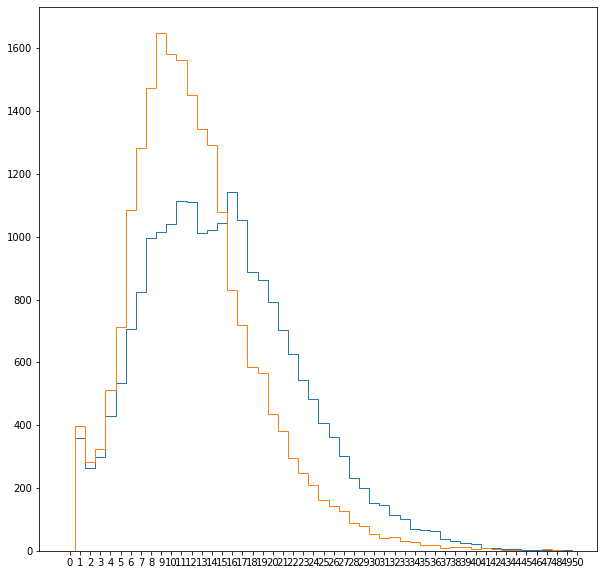

In [25]:
### Train classifier to distinguish between S' anb B' using jet2 features
train_ind = np.arange(0, int(len(balanced_idxs) * (1 - val_frac)))
val_ind = np.arange(int(len(balanced_idxs) * (1 - val_frac)), len(balanced_idxs))
X_train = j2_feats_for_nn[balanced_idxs][train_ind]
y_train = data.iloc[balanced_idxs].iloc[train_ind]["j1_mult_cut"]
bins=np.arange(-0.5,50,1)
plt.hist((X_train[y_train==1, :, 0] != 0).sum(axis=1), bins=bins, histtype='step');
plt.hist((X_train[y_train==0, :, 0] != 0).sum(axis=1), bins=bins, histtype='step');
plt.xticks(bins+0.5);
plt.gcf().set_size_inches(10, 10)

In [230]:
data[[feat+"2" for feat in feats]].head()

,track_D02,track_DZ2,track_PT2,track_Eta2,track_Phi2
0,"[-0.0579229, -0.310583, 0.537489, 0.124052, 0....","[0.06689559667893402, 0.04983237105358428, -0....","[1.0, 0.5957473597460473, 0.4934855930651365, ...","[-0.2856000000000014, -0.21050000000000013, 0....","[-1.9863000000000008, -2.753099999999997, -0.4..."
1,"[0.0161643, -0.05883, -0.0180341, -0.0375563, ...","[0.03867399344910346, 0.01766138177852015, -0....","[1.0, 0.9599182461437152, 0.5841611221897112, ...","[-0.20202000000000053, -0.5371300000000001, 0....","[0.5945550000000001, -0.19048099999999998, 1.0..."
2,"[-0.0237458, 0.15661, 0.0595561, 0.151475, -0....","[-0.00604398186345781, -0.0633603752357697, -0...","[1.0, 0.39053803662807923, 0.33072204829144475...","[0.21440000000000126, 0.10709999999999997, 0.4...","[-0.10380000000000056, 0.23260000000000058, 0...."
3,"[0.0073765, -0.18721, -0.151991, 0.0601969, -0...","[-0.02065830155854374, -0.049200908687191264, ...","[1.0, 0.4735972867359729, 0.3246741543578527, ...","[0.4457000000000022, 0.4773000000000005, 0.585...","[-0.8235800000000004, 1.9535599999999997, 1.97..."
4,"[0.0607243, -0.198062, -0.0295587, 0.052947, 0...","[0.026828413407531553, 0.0324218995668734, 0.0...","[1.0, 0.8587321578505457, 0.6937815782108504, ...","[0.050799999999999734, 0.15249999999999986, -0...","[0.25519999999999765, -0.6630000000000003, 0.1..."


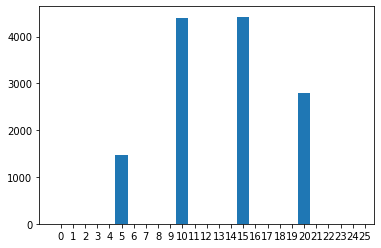

In [194]:
bins=np.arange(-0.5,25,1)
plt.hist((X_train[y_train==1, :, 0] != 0).sum(axis=1), bins=bins);
plt.xticks(bins+0.5);

In [199]:
plt.scatter((X_train[y_train==1, :, 0] != 0).sum(axis=1), )

TypeError: scatter() missing 1 required positional argument: 'y'

In [191]:
bins.shape

(26,)

In [172]:
y_train.shape

(30641,)

In [173]:
X_train.shape

(30641, 25, 5)

In [167]:
sum(y_train)/len(y_train)

0.4994615058255279